# Когортный анализ

![](http://d35fo82fjcw0y8.cloudfront.net/2016/03/03210554/table1a2.png)

In [31]:
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [15]:
df = pd.read_csv('retail_dataset.csv', parse_dates=['purchasedate'])

In [16]:
df.head(5)

,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1.0
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1.0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   purchaseid       105335 non-null  object        
 1   item_ID          105335 non-null  object        
 2   Quantity         105335 non-null  int64         
 3   purchasedate     105335 non-null  datetime64[ns]
 4   CustomerID       69125 non-null   float64       
 5   ShopID           105335 non-null  object        
 6   loyalty_program  105335 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 5.6+ MB


Check and Clean Missing Data 

In [18]:
df.isnull().sum()

purchaseid             0
item_ID                0
Quantity               0
purchasedate           0
CustomerID         36210
ShopID                 0
loyalty_program        0
dtype: int64

In [20]:
df = df.dropna(subset=['CustomerID'])

In [21]:
df.isnull().sum().sum()

0

In [22]:
df.duplicated().sum()

971

In [23]:
df = df.drop_duplicates()

In [24]:
df.duplicated().sum()

0

In [25]:
df.describe()

,Quantity,CustomerID,loyalty_program
count,68154.000000,68154.000000,68154.000000
mean,11.119890,21011.165889,0.343516
std,406.602498,1766.665163,0.474885
min,-74216.000000,18025.000000,0.000000
25%,1.000000,19533.000000,0.000000
50%,4.000000,20977.000000,0.000000
75%,11.000000,22633.000000,1.000000
max,74214.000000,23962.000000,1.000000


In [26]:
df = df[(df['Quantity'] > 0)]
df.describe()

,Quantity,CustomerID,loyalty_program
count,53884.000000,53884.000000,53884.000000
mean,15.925006,20898.608622,0.322675
std,324.248449,1769.586855,0.467504
min,1.000000,18025.000000,0.000000
25%,2.000000,19373.000000,0.000000
50%,5.000000,20769.000000,0.000000
75%,11.000000,22522.000000,1.000000
max,74214.000000,23962.000000,1.000000


In [13]:
df.shape

(53884, 7)

## Cohort Analysis

Для когортного анализа нам нужно создать несколько ярлыков:

- Период: строковое представление года и месяца отдельной транзакции.
- Когортная группа: строковое представление года и месяца первой покупки покупателя. Этот ярлык является общим для всех счетов для конкретного клиента.
- Период когорты / индекс когорты: целое число, представляющее стадию «жизни» клиента. Число представляет количество месяцев, прошедших с момента первой покупки.

In [33]:
def get_month(date):
    return datetime.datetime(date.year, date.month, 1)

df['InvoiceMonth'] = df['purchasedate'].apply(get_month)
grouping = df.groupby('CustomerID')['InvoiceMonth']
df['CohortMonth'] = grouping.transform('min')
df.tail()

,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program,InvoiceMonth,CohortMonth
105320,539840,21126,11,2016-12-22 14:28:00,18062.0,Shop 12,0.0,2016-12-01,2016-12-01
105328,537886,22158,7,2016-12-09 09:49:00,21339.0,Shop 0,0.0,2016-12-01,2016-12-01
105332,538068,85048,1,2016-12-09 14:05:00,23657.0,Shop 0,1.0,2016-12-01,2016-12-01
105333,538207,22818,11,2016-12-10 11:33:00,18427.0,Shop 0,0.0,2016-12-01,2016-12-01
105334,543977,22384,9,2017-02-14 15:35:00,21294.0,Shop 0,0.0,2017-02-01,2016-12-01


In [34]:
def get_cohort_index(df, columns):
    year_diff = df[columns[0]].dt.year - df[columns[1]].dt.year
    month_diff = df[columns[0]].dt.month - df[columns[1]].dt.month
    return year_diff * 12 + month_diff + 1

In [36]:
df['CohortIndex'] = get_cohort_index(df, ['InvoiceMonth', 'CohortMonth'])

In [37]:
# Count monthly active customers from each cohort
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
# Return number of unique elements in the object.
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')
cohort_counts

CohortIndex,1,2,3
CohortMonth,,,
2016-12-01,881.0,321.0,284.0
2017-01-01,415.0,92.0,NaN
2017-02-01,375.0,NaN,NaN


In [63]:
# Retention table
cohort_size = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_size, axis=0) #axis=0 to ensure the divide along the row axis 
# retention.index = retention.index.date
retention.round(3) * 100 #to show the number as percentage 

CohortIndex,1,2,3
CohortMonth,,,
2016-12-01,100.0,36.4,32.2
2017-01-01,100.0,22.2,NaN
2017-02-01,100.0,NaN,NaN


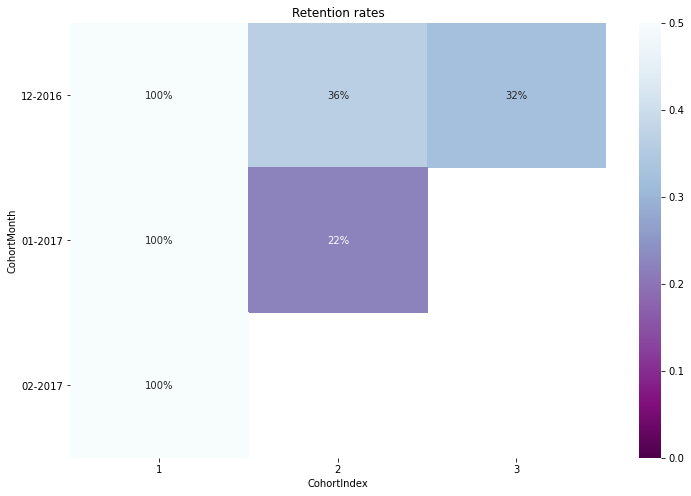

In [71]:
from matplotlib.dates import DateFormatter
#Build the heatmap
fig, ax = plt.subplots(figsize=(12, 8))
plt.title('Retention rates')
sns.heatmap(data=retention, annot=True, fmt='.0%', vmin=0.0, vmax=0.5, cmap="BuPu_r")
ax.set_yticklabels([x.date().strftime("%m-%Y") for x in retention.index], ha='right');
#date_form = DateFormatter("%Y-%m")
#ax.yaxis.set_major_formatter(date_form)

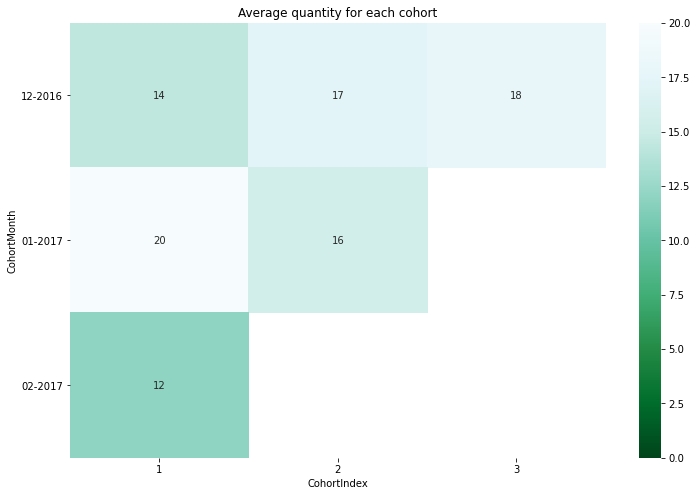

In [70]:
#Average quantity for each cohort
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['Quantity'].mean()
cohort_data = cohort_data.reset_index()
average_quantity = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='Quantity')
average_quantity.round(1)
# average_quantity.index = average_quantity.index.date

#Build the heatmap
fig, ax = plt.subplots(figsize=(12, 8))
plt.title('Average quantity for each cohort')
sns.heatmap(data=average_quantity, annot=True, vmin=0.0, vmax=20, cmap="BuGn_r")
ax.set_yticklabels([x.date().strftime("%m-%Y") for x in average_quantity.index], ha='right');